In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import helper_functions
reload(helper_functions)
from helper_functions import accuracy_rate, load_data, capacity, get_good_idx, get_slice, get_k_fold_cv_idx, get_x_sequences_3d, train, get_all_accuracy_rates


In [1]:
np.random.seed(2021)

case=1
x,x_time,y,y_time,time_dif,idx_offset = load_data(case)

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
pred_seq_len = 6*4+1


#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-pred_seq_len+1:i+idx_offset+1])

good_idx = get_good_idx(x,y,idx_offset,pred_seq_len)


print(x.shape)
print(y.shape)
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([182918, 16])
torch.Size([147205, 1])
2016-01-01 20:00:00
2017-01-07 20:15:00
137893


In [2]:
input_size = x.shape[1]
num_channels = input_size
hidden_size1 = 50
hidden_size2 = 50
out_size = 1

kernel_size = 7
stride = 3
padding = 3
conv_out_seq = round((pred_seq_len + 2*padding - kernel_size) / stride + 1)
print(conv_out_seq)
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        
        self.conv = nn.Conv1d(in_channels = input_size, 
                              out_channels = num_channels, 
                              kernel_size = kernel_size, 
                              stride=stride, 
                              padding=padding,
                              groups = input_size)
        self.lstm = nn.LSTM(input_size=num_channels,
                            hidden_size=hidden_size1,
                            batch_first=True, # batch_size x sequence_length x input_size
                            bias=True)
        self.gru = nn.GRU(input_size=num_channels,
                            hidden_size=hidden_size1,
                            batch_first=True, # batch_size x sequence_length x input_size
                            bias=True)
        self.l1 = nn.Linear(in_features=hidden_size1 * conv_out_seq,
                               out_features=hidden_size2,
                               bias=True)
        self.l_out = nn.Linear(in_features=hidden_size2,
                               out_features=out_size,
                               bias=True)
        
        self.act = nn.ReLU()
        
        
    def forward(self, x):
        x = self.conv(x) ## remove this
        x = x.reshape(-1, conv_out_seq, num_channels)
        
        #x, (h, c) = self.lstm(x)
        
        x, h = self.gru(x)
        
        #x = x[:, -1, :]
        x = x.reshape(-1, hidden_size1 * conv_out_seq)
        
        x = self.act(x)
        x = self.l1(x)
        x = self.act(x)
        x = self.l_out(x)
        return x


net = Net()
print(net)

optimizer = optim.Adam(net.parameters())
loss = nn.MSELoss()

9
Net(
  (conv): Conv1d(16, 16, kernel_size=(7,), stride=(3,), padding=(3,), groups=16)
  (lstm): LSTM(16, 50, batch_first=True)
  (gru): GRU(16, 50, batch_first=True)
  (l1): Linear(in_features=450, out_features=50, bias=True)
  (l_out): Linear(in_features=50, out_features=1, bias=True)
  (act): ReLU()
)


In [4]:
"""

# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 10



k_fold_size = 5






fold=0
valid_idx, train_idx = get_k_fold_cv_idx(fold, good_idx, k_fold_size)

num_samples_train = train_idx.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = valid_idx.shape[0]
num_batches_valid = num_samples_valid // batch_size

x_input = torch.zeros(batch_size, input_size, pred_seq_len)

# setting up lists for handling loss/accuracy
train_rmse = []
valid_rmse = []
cur_loss = 0

for epoch in range(num_epochs):
    ## Training
    # Forward -> Backprob -> Update params
    net.train()
    cur_loss = 0
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)

        get_x_sequences_3d(train_idx[slce], x_input, idx_offset, pred_seq_len, x)
        
        output = net(x_input)

        # compute gradients given loss
        batch_loss = loss(output, y[train_idx[slce]])
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    train_rmse.append(np.sqrt(cur_loss.detach().numpy() / num_batches_train))

    ## Validation
    net.eval()
    cur_loss = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        get_x_sequences_3d(valid_idx[slce], x_input, idx_offset, pred_seq_len, x)
        
        output = net(x_input)
        
        # compute loss
        batch_loss = loss(output, y[valid_idx[slce]])
        
        cur_loss += batch_loss  
    valid_rmse.append(np.sqrt(cur_loss.detach().numpy() / num_batches_valid))
    

    
    if epoch % (num_epochs//10) == 0:
        print("Epoch %2i : Train RMSE %f , Valid RMSE %f" % (
                epoch, train_rmse[-1], valid_rmse[-1]))


        
"""
        
# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 10
k_fold_size = 5

loss = nn.MSELoss()
valid_metrics = [nn.MSELoss()]
x_batch = torch.zeros(batch_size, input_size, pred_seq_len)


train_loss, valid_loss = train(x_batch, x, y, net, num_epochs, batch_size, good_idx, k_fold_size, get_x_sequences_3d, idx_offset, pred_seq_len, loss, valid_metrics)


Epoch  0 : Training loss: 0.3070, Validation: MSELoss 0.2443
Epoch  1 : Training loss: 0.2223, Validation: MSELoss 0.2105
Epoch  2 : Training loss: 0.2079, Validation: MSELoss 0.1989
Epoch  3 : Training loss: 0.2003, Validation: MSELoss 0.1949
Epoch  4 : Training loss: 0.1962, Validation: MSELoss 0.1924
Epoch  5 : Training loss: 0.1944, Validation: MSELoss 0.1912
Epoch  6 : Training loss: 0.1931, Validation: MSELoss 0.1900
Epoch  7 : Training loss: 0.1919, Validation: MSELoss 0.1891
Epoch  8 : Training loss: 0.1908, Validation: MSELoss 0.1882
Epoch  9 : Training loss: 0.1897, Validation: MSELoss 0.1873


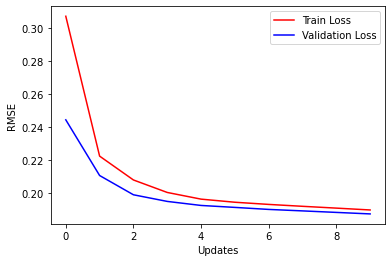

In [5]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss[0, :], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('RMSE')
plt.show()

In [6]:
x_batch = torch.zeros(len(good_idx), input_size, pred_seq_len)
predictions = net(get_x_sequences_3d(good_idx, x_batch, idx_offset, pred_seq_len, x)).detach().numpy()

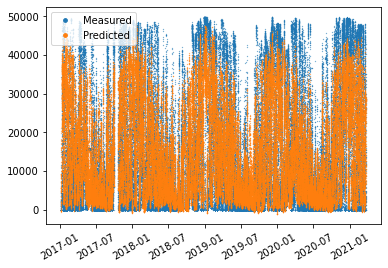

In [7]:
plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy(), '.', markersize=0.5, label = 'Measured')
plt.plot(y_time[good_idx], capacity(case)*predictions,'.', markersize=0.5, label = 'Predicted')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()

In [ ]:
sorted_good = sorted(good_idx)[-96:]
np.all(np.diff(sorted_good)==1)
x_input = torch.zeros(96, input_size, pred_seq_len)
get_x_sequences_3d(sorted_good, x_input, idx_offset, pred_seq_len, x)
net.eval()
P_P = np.zeros(96)
P_M = np.zeros(96)

P_M = y[sorted_good].detach().numpy() * capacity(case)
P_P = net(x_input).detach().numpy() * capacity(case)

print(accuracy_rate(P_P, P_M, capacity(case)))

plt.plot(y_time[sorted_good], P_P, label = 'Predicted')
plt.plot(y_time[sorted_good], P_M, label = 'Measured')
plt.legend()
plt.show()

In [17]:
x_batch = torch.zeros(96, input_size, pred_seq_len)
accuracies, times = get_all_accuracy_rates(net, x, y, y_time, x_batch, get_x_sequences_3d, good_idx, idx_offset, pred_seq_len, case)

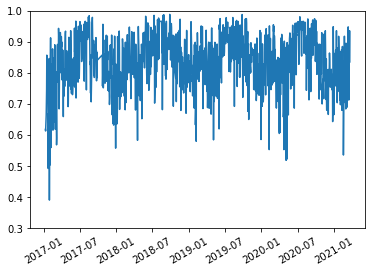

0.8354199204165601


In [20]:
plt.plot(times, accuracies)
plt.xticks(rotation=30)
plt.ylim(0.3,1)
plt.show()
print(np.mean(accuracies))